In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd

# Configuration

### Inputs

In [2]:
process_out_dir = '../../01_process/out/'

valid_data_fpath = process_out_dir + 'valid_data.npz'


train_out_dir = '../../02_train/out/'

eval_out_dir = '../../03_eval/out/'

mapping_reference = "../../01_process/in/MN_ice/raw_data_from_DNR/lake_ice_id_spreadsheet.xlsx"

remove_PB = True

if remove_PB:
    # we'll rescale data to compare it to training domain
    avg_data_scalars_fpath =  train_out_dir + 'avg_lstm_min_max_scalars_4_NoProcessBasedInput_.pt'
    massive_data_scalars_fpath =  train_out_dir + 'massive_lstm_min_max_scalars_0_NoProcessBasedInput_.pt'
    # loss lists for scaling permutation results
    avg_loss_list_fpath = train_out_dir + 'avg_lstm_loss_lists_4_NoProcessBasedInput_.npz'
    massive_loss_list_fpath = train_out_dir + 'massive_lstm_loss_lists_0_NoProcessBasedInput_.npz'

    # best avg lstm
    avg_rand_valid_set_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_coarse_4_NoProcessBasedInput_.npz'
    avg_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_on_4_NoProcessBasedInput_.npz'
    avg_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_off_4_NoProcessBasedInput_.npz'
    avg_valid_set_permutation_fpath = eval_out_dir + 'avg_lstm_permutation_results_4_NoProcessBasedInput_.npy'
    avg_valid_set_ICE_vals_fpath = eval_out_dir + 'avg_lstm_valid_ICE_vals_4_NoProcessBasedInput_.npy'
    avg_valid_set_ICE_preds_fpath = eval_out_dir + 'avg_lstm_valid_ICE_preds_4_NoProcessBasedInput_.npy'

    # best massive lstm
    massive_rand_valid_set_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_coarse_0_NoProcessBasedInput_.npz'
    massive_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_on_0_NoProcessBasedInput_.npz'
    massive_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_off_0_NoProcessBasedInput_.npz'
    massive_valid_set_permutation_fpath = eval_out_dir + 'massive_lstm_permutation_results_0_NoProcessBasedInput_.npy'
    massive_valid_set_ICE_vals_fpath = eval_out_dir + 'massive_lstm_valid_ICE_vals_0_NoProcessBasedInput_.npy'
    massive_valid_set_ICE_preds_fpath = eval_out_dir + 'massive_lstm_valid_ICE_preds_0_NoProcessBasedInput_.npy'
    
else:
    # we'll rescale data to compare it to training domain
    avg_data_scalars_fpath =  train_out_dir + 'avg_lstm_min_max_scalars_3_.pt'
    massive_data_scalars_fpath =  train_out_dir + 'massive_lstm_min_max_scalars_1_.pt'
    # loss lists for scaling permutation results
    avg_loss_list_fpath = train_out_dir + 'avg_lstm_loss_lists_3_.npz'
    massive_loss_list_fpath = train_out_dir + 'massive_lstm_loss_lists_1_.npz'

    # best avg lstm
    avg_rand_valid_set_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_coarse_3_.npz'
    avg_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_on_3_.npz'
    avg_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'avg_lstm_random_valid_eg_ice_off_3_.npz'
    avg_valid_set_permutation_fpath = eval_out_dir + 'avg_lstm_permutation_results_3_.npy'
    avg_valid_set_ICE_vals_fpath = eval_out_dir + 'avg_lstm_valid_ICE_vals_3_.npy'
    avg_valid_set_ICE_preds_fpath = eval_out_dir + 'avg_lstm_valid_ICE_preds_3_.npy'

    # best massive lstm
    massive_rand_valid_set_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_coarse_1_.npz'
    massive_rand_valid_ice_on_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_on_1_.npz'
    massive_rand_valid_ice_off_EGs_fpath = eval_out_dir + 'massive_lstm_random_valid_eg_ice_off_1_.npz'
    massive_valid_set_permutation_fpath = eval_out_dir + 'massive_lstm_permutation_results_1_.npy'
    massive_valid_set_ICE_vals_fpath = eval_out_dir + 'massive_lstm_valid_ICE_vals_1_.npy'
    massive_valid_set_ICE_preds_fpath = eval_out_dir + 'massive_lstm_valid_ICE_preds_1_.npy'


# Not values, because they are constrained by previous notebooks
n_eg = 50
n_eg_fine = 50
perm_samples = 200
resolution = 25 # ICE

### Values

In [3]:
ice_on_start = 50
ice_on_end = 215

ice_off_start = 215
ice_off_end = 350

<br><br><br>

# Load data

In [4]:
valid_data = np.load(valid_data_fpath, allow_pickle = True)

valid_x = valid_data['x']
valid_dates = valid_data['dates']
valid_DOW = valid_data['DOW'] # Minnesota lake identifier
valid_variables = valid_data['features']

In [5]:
# Remove the process-based estimate if desired
if remove_PB:
    # remove estimate of ice
    valid_ice_loc = np.argwhere(valid_variables == 'ice').item()
    valid_x = np.delete(valid_x, valid_ice_loc, -1)
    valid_variables = np.delete(valid_variables, valid_ice_loc)
    
    
    # remove estimate of surface water temp
    valid_temp_0_x_loc = np.argwhere(valid_variables == 'temp_0_x').item()
    valid_x = np.delete(valid_x, valid_temp_0_x_loc, -1)
    valid_variables = np.delete(valid_variables, valid_temp_0_x_loc)
    
else:
    print('Keeping proces-based estimate')

In [6]:
valid_x = torch.from_numpy(valid_x).float()

# load the data scalars and ensure they're the same (data-based, not model-based)
massive_min_max_scalars = torch.load(massive_data_scalars_fpath)
avg_min_max_scalars = torch.load(avg_data_scalars_fpath)
assert torch.equal(massive_min_max_scalars, avg_min_max_scalars)

# rescale valid x
for i in range(valid_x.shape[2]):
    # scale valid set with train min/max
    valid_x[:, :, i] = ((valid_x[:, :, i] - avg_min_max_scalars[i, 0]) /
                        (avg_min_max_scalars[i, 1] - avg_min_max_scalars[i, 0]))

# Load previously calculcated XAI results

In [7]:
# Load expected gradients for both models - coarse, ice on, and ice off
avg_valid_eg = np.load(avg_rand_valid_set_EGs_fpath, allow_pickle = True)
avg_valid_eg_ice_on = np.load(avg_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
avg_valid_eg_ice_off = np.load(avg_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
massive_valid_eg = np.load(massive_rand_valid_set_EGs_fpath, allow_pickle = True)
massive_valid_eg_ice_on = np.load(massive_rand_valid_ice_on_EGs_fpath, allow_pickle = True)
massive_valid_eg_ice_off = np.load(massive_rand_valid_ice_off_EGs_fpath, allow_pickle = True)
# Extract the data
avg_valid_eg_results = avg_valid_eg['results']
avg_valid_eg_results_ice_on = avg_valid_eg_ice_on['results']
avg_valid_eg_results_ice_off = avg_valid_eg_ice_off['results']
massive_valid_eg_results = massive_valid_eg['results']
massive_valid_eg_results_ice_on = massive_valid_eg_ice_on['results']
massive_valid_eg_results_ice_off = massive_valid_eg_ice_off['results']
# Extract the associated IDs
avg_valid_eg_IDs = avg_valid_eg['ids']
avg_valid_eg_IDs_ice_on = avg_valid_eg_ice_on['ids']
avg_valid_eg_IDs_ice_off = avg_valid_eg_ice_off['ids']
massive_valid_eg_IDs = massive_valid_eg['ids']
massive_valid_eg_IDs_ice_on = massive_valid_eg_ice_on['ids']
massive_valid_eg_IDs_ice_off = massive_valid_eg_ice_off['ids']

# Load permutation results
avg_permutation_results = np.load(avg_valid_set_permutation_fpath)
avg_valid_set_ICE_vals = np.load(avg_valid_set_ICE_vals_fpath)
avg_valid_set_ICE_preds = np.load(avg_valid_set_ICE_preds_fpath)

# Load ICE results
massive_permutation_results = np.load(massive_valid_set_permutation_fpath)
massive_valid_set_ICE_vals = np.load(massive_valid_set_ICE_vals_fpath)
massive_valid_set_ICE_preds = np.load(massive_valid_set_ICE_preds_fpath)

In [8]:
avg_valid_loss_list = np.load(avg_loss_list_fpath, allow_pickle = True)['valid_loss']
massive_valid_loss_list = np.load(massive_loss_list_fpath, allow_pickle = True)['valid_loss']

In [9]:
# make sure all the EGs are for the same sequences
assert np.sum(avg_valid_eg_IDs == massive_valid_eg_IDs) / n_eg == 1
assert np.sum(avg_valid_eg_IDs_ice_on == massive_valid_eg_IDs_ice_on) / n_eg_fine == 1
assert np.sum(avg_valid_eg_IDs_ice_off == massive_valid_eg_IDs_ice_off) / n_eg_fine == 1

# make sure they match across EG types
assert np.sum(avg_valid_eg_IDs == avg_valid_eg_IDs_ice_on) / n_eg == 1
assert np.sum(avg_valid_eg_IDs == avg_valid_eg_IDs_ice_off) / n_eg == 1

# Utility functions

In [10]:
def get_relative_abs_attribution_by_var(EGs):
    
    ### function that makes all EG attributions positive ###
    ### then sums across batch/lakes and time ###
    ### Ultimately, it aggregates EG attribution magnitude by variable ###
    
    ### assumes EGs are of shape = [unique lake year(s), time steps, variables] ###


    # get total absolute attribution for each sequence (for scaling)
    all_total_abs_attribution = np.sum(np.sum(np.abs(EGs), axis = 1), axis = 1)

    # object to store in
    all_relative_attributions = np.zeros([EGs.shape[0], EGs.shape[2]])
    # for every sequence...
    for i in range(EGs.shape[0]):
        # sum the absolute attribution along all time steps per variable, then scale variables' attribution
        # so that their sum is 1
        cur_relative_attributions = np.sum(np.abs(EGs[i]), axis = 0) / all_total_abs_attribution[i]
        all_relative_attributions[i] = cur_relative_attributions
        
    return np.mean(all_relative_attributions, axis = 0)


def calc_num_attributed_days(subset_EGs):
    
    ### function that scans through a time series of EGs... ###
    ### then determines where 5% of attributions have accumulated ###
    ### and where 99.99% of attributions end ###
    ### taking the difference to determine how many days account for ~95% of attributions ###

    # subset_EGs are EGs associated with 1 time series (batch size = 1)

    # absolute value of attributions for total affecting-potential on preds
    magnitude_attribution = np.abs(subset_EGs)
    # determine value of all attributions
    total_attribution = np.sum(magnitude_attribution)

    # through time determine cumulative attribution
    running_attribution = np.cumsum(np.sum(magnitude_attribution, axis = 1))

    # identify where 95% of attribution *starts*
    start_attribution = np.argwhere((running_attribution / total_attribution) >= 0.05)[0].item()
    # identify where 99.99% of attribution *ends*, 100% was faulty
    end_attribution = np.argwhere((running_attribution / total_attribution) >= 0.9999)[0].item()
    # calc diff
    num_attributed_days = end_attribution - start_attribution
    
    return num_attributed_days

# Plot sum of absolute values of EGs across space and time


Avg model increasing importance:	 ['Rain' 'LakeArea' 'Snow' 'RelHum' 'WindSpeed' 'MaxDepth' 'ShortWave'
 'LongWave' 'AirTemp'] 

 
Massive model increasing importance:	 ['Rain' 'LakeArea' 'Snow' 'RelHum' 'WindSpeed' 'MaxDepth' 'ShortWave'
 'LongWave' 'AirTemp']


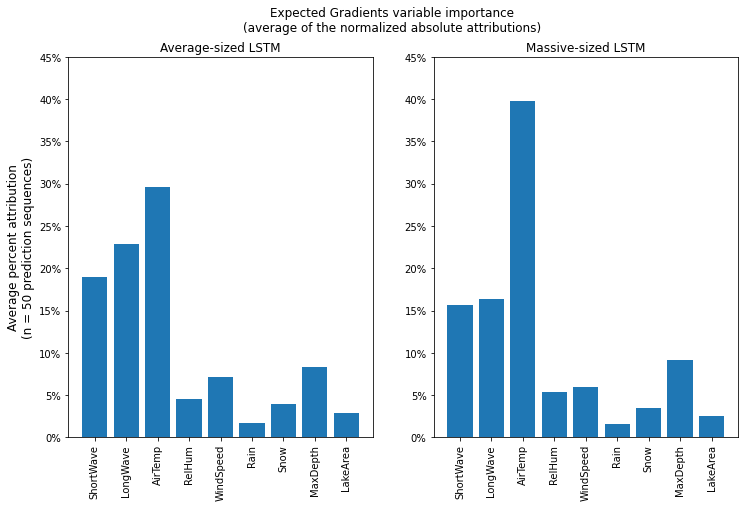

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))

fig.suptitle('Expected Gradients variable importance\n(average of the normalized absolute attributions)')

# Take the absolute value of EGs and aggregrate them across lakes and days
avg_rel_abs_attribution_by_var = get_relative_abs_attribution_by_var(avg_valid_eg_results)
massive_rel_abs_attribution_by_var = get_relative_abs_attribution_by_var(massive_valid_eg_results)

# Determine a shared y-maximum for plotting
ymax = np.max([np.max(avg_rel_abs_attribution_by_var),
               np.max(massive_rel_abs_attribution_by_var)])
ymax = ymax + ymax*0.05

# Plot both
ax[0].bar(range(len(valid_variables)),
          avg_rel_abs_attribution_by_var)
ax[0].set_ylabel('Average percent attribution\n(n = ' +
                 str(n_eg) + ' prediction sequences)',
                 fontsize = 12)
ax[0].set_title('Average-sized LSTM');

ax[1].bar(range(len(valid_variables)),
          massive_rel_abs_attribution_by_var)
ax[1].set_title('Massive-sized LSTM')

for i in range(2):
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)
    ax[i].set_ylim(0, ymax)
    ax[i].set_yticks(ax[i].get_yticks(), [str(int(100*tick))+'%' for tick in ax[i].get_yticks()])
    
print('\nAvg model increasing importance:\t', valid_variables[np.argsort(avg_rel_abs_attribution_by_var)], '\n\n',
      '\nMassive model increasing importance:\t', valid_variables[np.argsort(massive_rel_abs_attribution_by_var)])

##### When using process-based inputs

The relative importance of variables is pretty similar. Both models favor the following top-3 variables:
* air temperature
* process-based estimate of ice (`ice`)
* process-based estimate of surface water temperature (`temp_0_x`)

Relative ordering and magnitude of the top variables looks highly agreeable except the `massive lstm` places more emphasis on `ice`, seemingly at the expense of relative humidity and wind speed.

##### When NOT using process-based inputs

The relative importance of variables is pretty similar. Both models favor the following top-3 variables:
* air temperature
* longwave radiation
* shortwave radiation

Overall, the relative ordering and magnitude is highly agreeable. The most significant difference is that the massive LSTM more heavily emphasizes `AirTemp` at the expense of `LongWave` and `ShortWave`

<br><br><br><br><br>

# Plot EGs for individual sequences

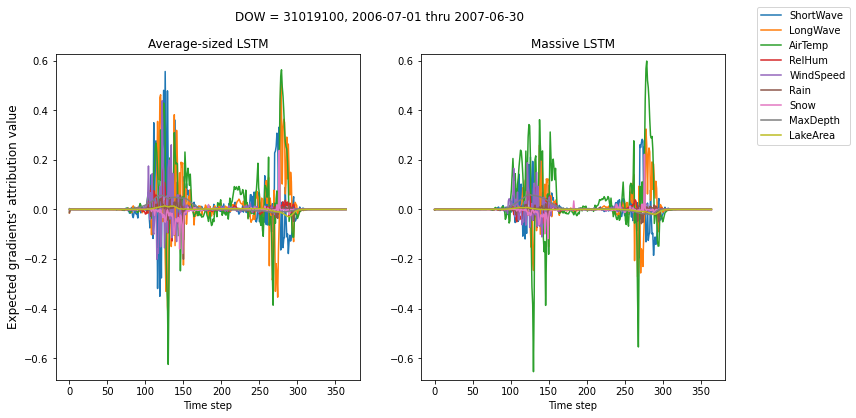

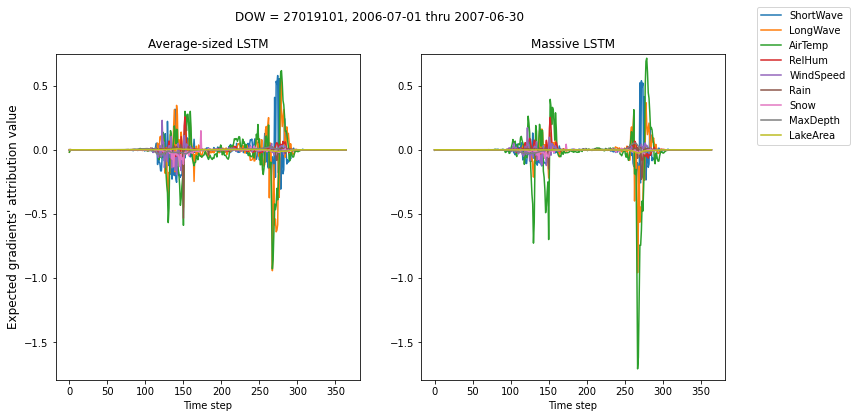

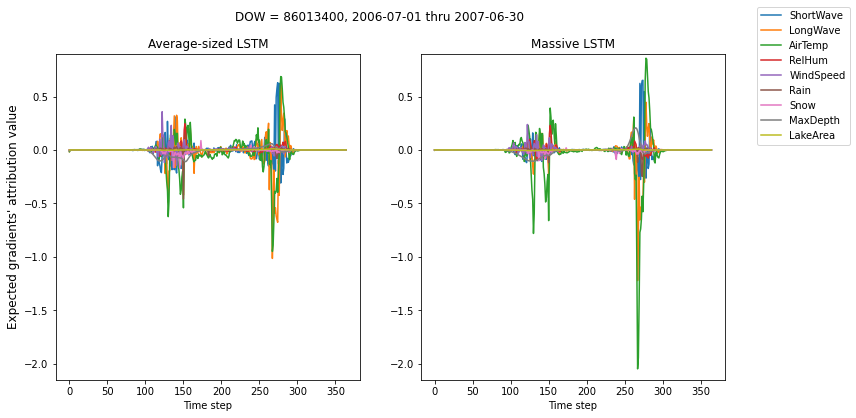

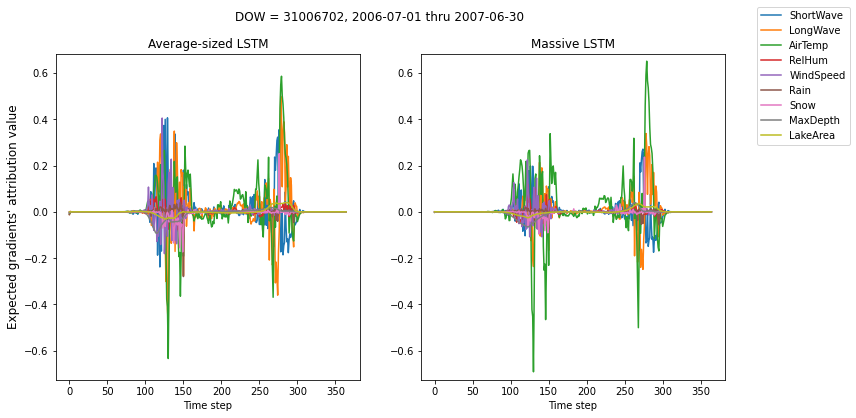

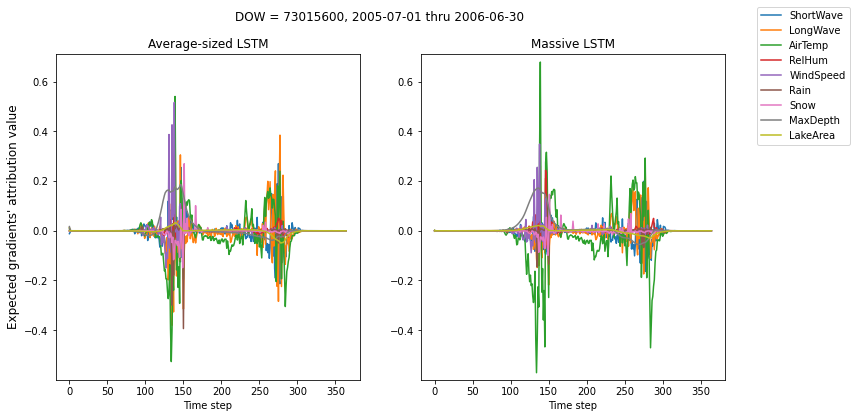

In [12]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    
    # draw a random index
    rand_i = np.random.choice(n_eg)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs[rand_i]][0]
    rand_end_date = valid_dates[avg_valid_eg_IDs[rand_i]][-1]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    # plot
    for var_i in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results[rand_i, :, var_i])
        ax[1].plot(massive_valid_eg_results[rand_i, :, var_i], label = valid_variables[var_i])
    for j in range(2):
        ax[j].set_ylim(ymin, ymax)
        ax[j].set_xlabel('Time step')
    ax[0].set_ylabel("Expected gradients' attribution value",
                     fontsize = 12)
    ax[0].set_title('Average-sized LSTM')
    ax[1].set_title('Massive LSTM')
    fig.legend(bbox_to_anchor = (1.05, 1))
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)

##### When using process-based inputs

Attributions are largely not occurring outside transition periods. That is, no attributions during the heat of summer or the dead of winter.

##### When NOT using process-based inputs

Attributes are smaller magnitude but still active outside transition periods. That is, attributions do occur during the dead of winter (but not the heat of summer)

<br><br><br><br><br>

# EGs targetted at predicted ice on transition

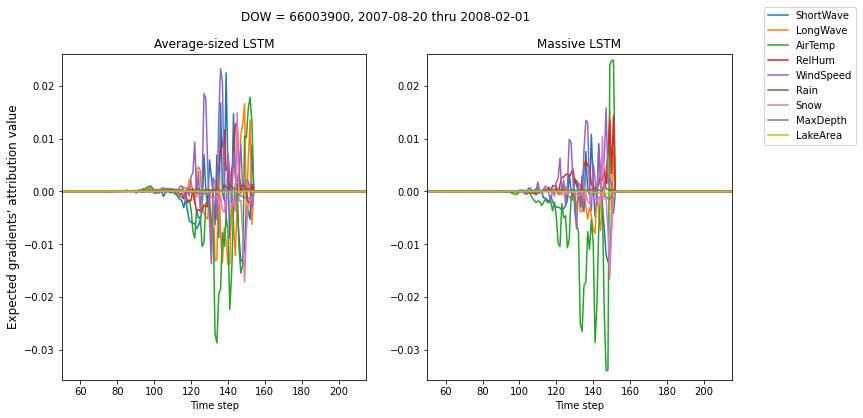

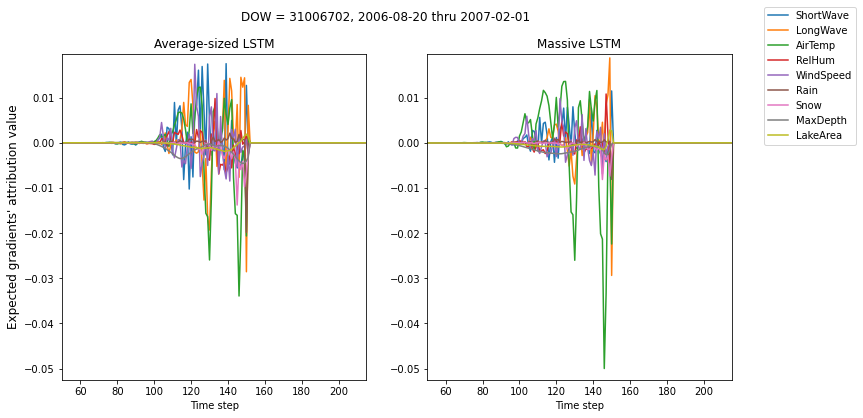

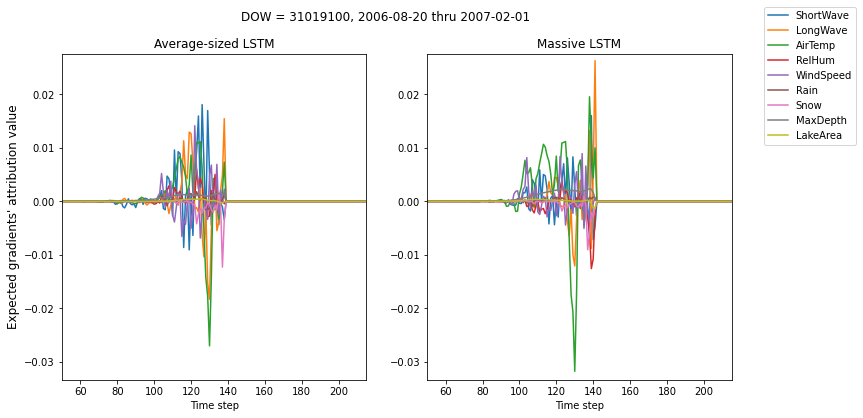

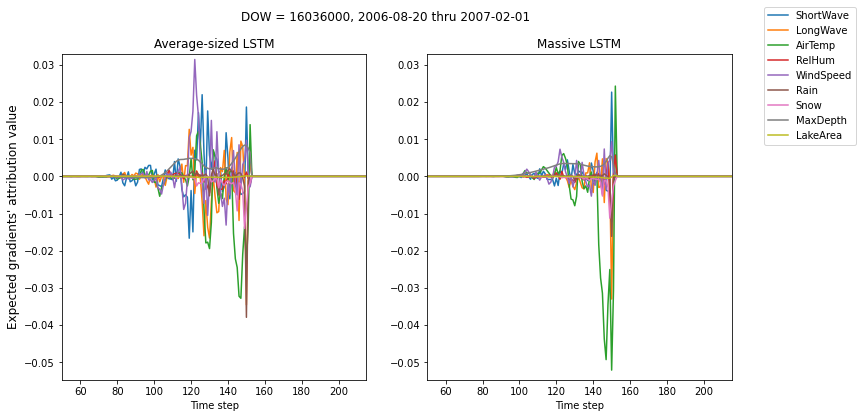

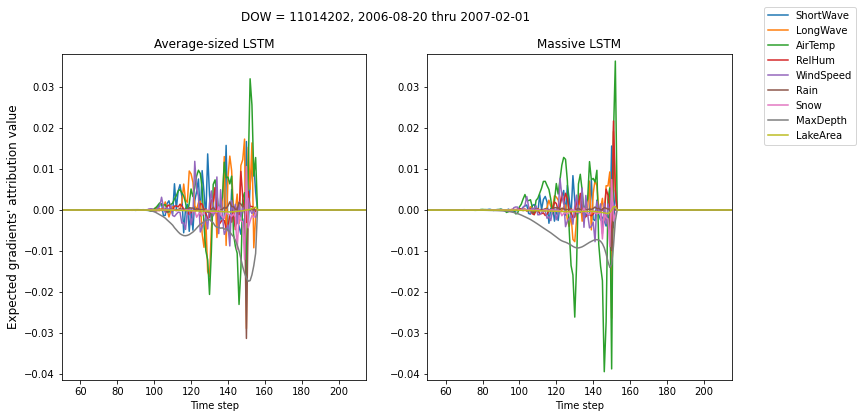

In [13]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    
    # draw a random index
    rand_i = np.random.choice(n_eg_fine)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs_ice_on[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs_ice_on[rand_i]][ice_on_start]
    rand_end_date = valid_dates[avg_valid_eg_IDs_ice_on[rand_i]][ice_on_end]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results_ice_on[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results_ice_on[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    for j in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results_ice_on[rand_i, :, j])
        ax[1].plot(massive_valid_eg_results_ice_on[rand_i, :, j], label = valid_variables[j])
    for k in range(2):
        ax[k].set_ylim(ymin, ymax)
        ax[k].set_xlim(ice_on_start, ice_on_end)
        ax[k].set_xlabel('Time step')
    ax[0].set_ylabel("Expected gradients' attribution value",
                     fontsize = 12)
    ax[0].set_title('Average-sized LSTM')
    ax[1].set_title('Massive LSTM')
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)
    fig.legend(bbox_to_anchor = (1.05, 1))

# EGs targetted at predicted ice off transition

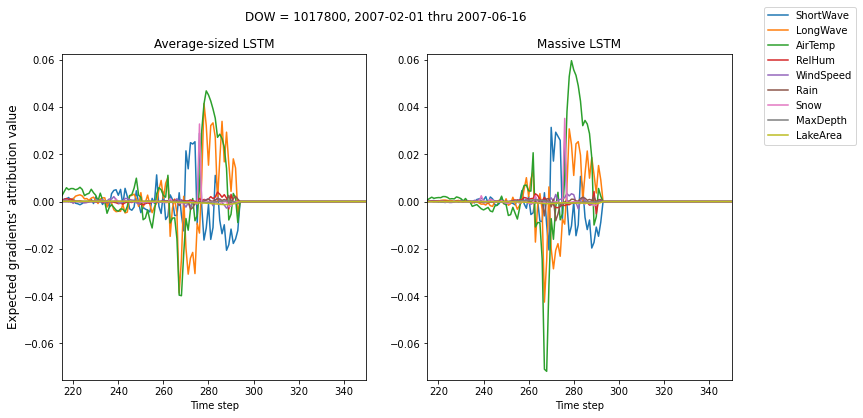

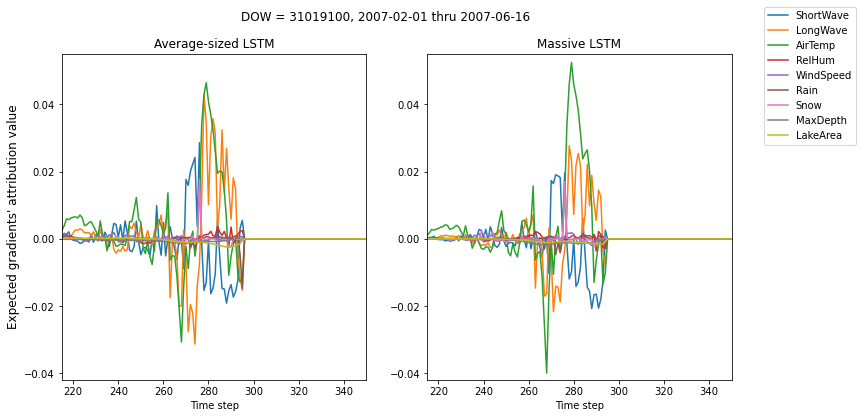

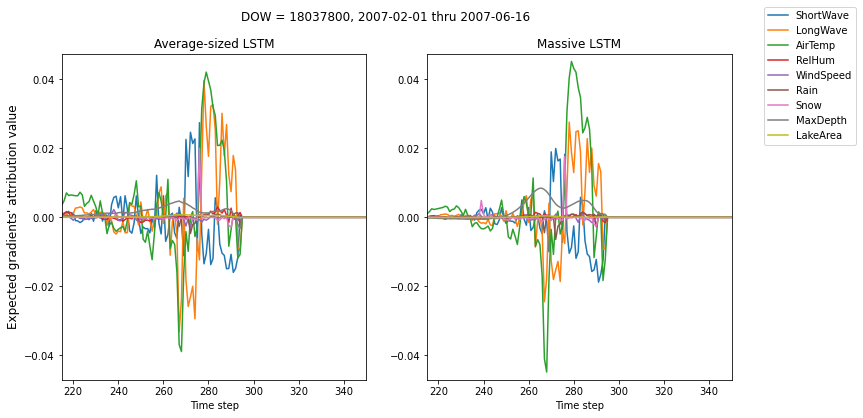

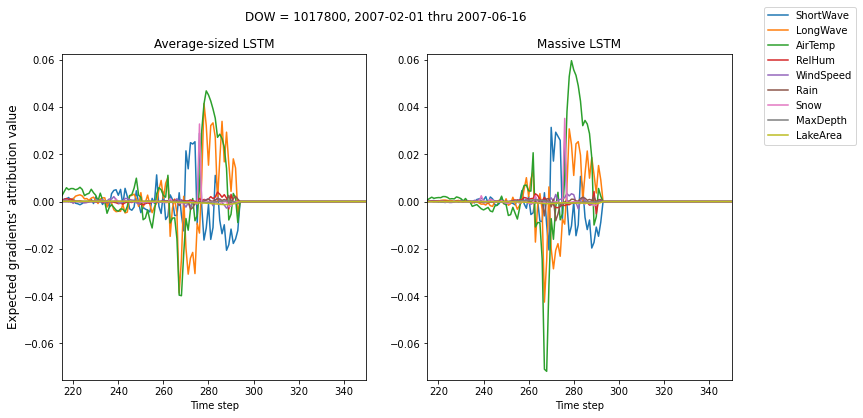

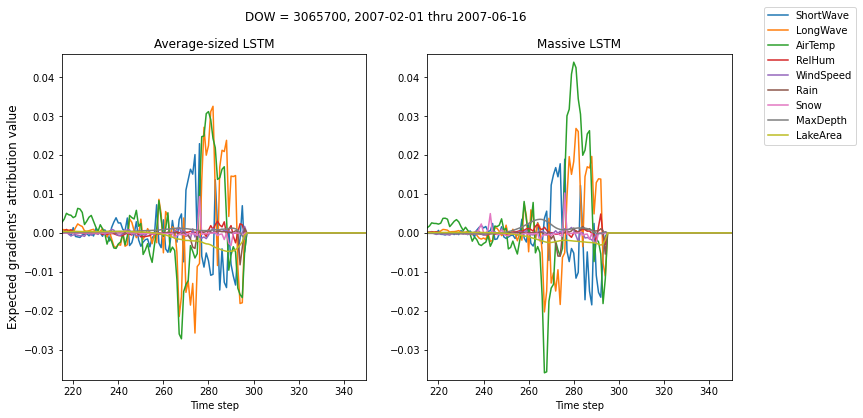

In [14]:
for i in range(5):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    
    # draw a random index
    rand_i = np.random.choice(n_eg_fine)
    
    # format some information with that random index
    rand_dow = str(valid_DOW[avg_valid_eg_IDs_ice_off[rand_i]])
    rand_start_date = valid_dates[avg_valid_eg_IDs_ice_off[rand_i]][ice_off_start]
    rand_end_date = valid_dates[avg_valid_eg_IDs_ice_off[rand_i]][ice_off_end]
    
    # get info to make axes the same
    avg_cur_egs = avg_valid_eg_results_ice_off[rand_i, :, :]
    massive_cur_egs = massive_valid_eg_results_ice_off[rand_i, :, :] 
    ymin = np.min([np.min(avg_cur_egs), np.min(massive_cur_egs)])
    ymax = np.max([np.max(avg_cur_egs), np.max(massive_cur_egs)])
    ymin = ymin + ymin*0.05
    ymax = ymax + ymax*0.05
    
    for j in range(len(valid_variables)):
        ax[0].plot(avg_valid_eg_results_ice_off[rand_i, :, j])
        ax[1].plot(massive_valid_eg_results_ice_off[rand_i, :, j], label = valid_variables[j])
    for k in range(2):
        ax[k].set_ylim(ymin, ymax)
        ax[k].set_xlim(ice_off_start, ice_off_end)
        ax[k].set_xlabel('Time step')
    ax[0].set_ylabel("Expected gradients' attribution value",
                     fontsize = 12)
    ax[0].set_title('Average-sized LSTM')
    ax[1].set_title('Massive LSTM')
    fig.suptitle('DOW = ' + rand_dow + ", " + rand_start_date + ' thru ' + rand_end_date)
    fig.legend(bbox_to_anchor = (1.05, 1))

##### When using process-based inputs

Compared to ice on prediction, ice off prediction appears to utilize more variables

##### When NOT using process-based inputs


Compared to ice on prediction, ice off prediction appears to utilize more variables and longer memory

<br><br><br><br><br>

# Compare how EGs vary when predicting ice-on versus ice-off transition

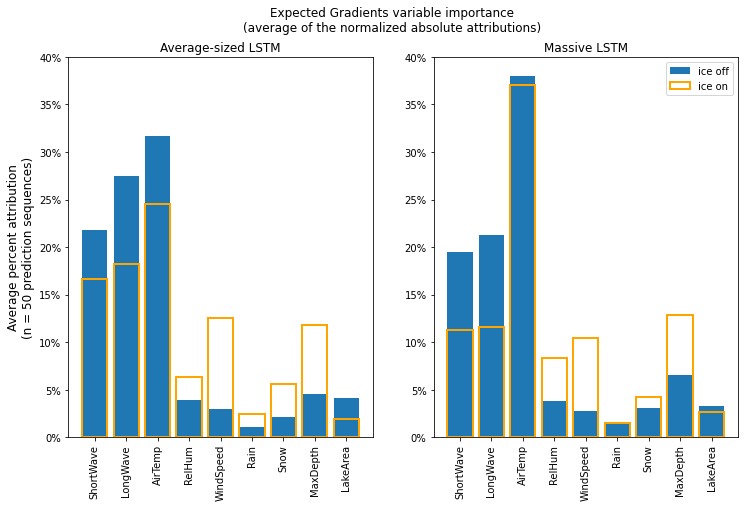

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))

fig.suptitle('Expected Gradients variable importance\n(average of the normalized absolute attributions)')

# Take the absolute value of EGs and aggregrate them across lakes and days
avg_rel_abs_attribution_by_var_ice_on = get_relative_abs_attribution_by_var(avg_valid_eg_results_ice_on)
avg_rel_abs_attribution_by_var_ice_off = get_relative_abs_attribution_by_var(avg_valid_eg_results_ice_off)
massive_rel_abs_attribution_by_var_ice_on = get_relative_abs_attribution_by_var(massive_valid_eg_results_ice_on)
massive_rel_abs_attribution_by_var_ice_off = get_relative_abs_attribution_by_var(massive_valid_eg_results_ice_off)

# Determine a shared y-maximum for plotting
ymax = np.max([np.max(avg_rel_abs_attribution_by_var_ice_on),
               np.max(avg_rel_abs_attribution_by_var_ice_off),
               np.max(massive_rel_abs_attribution_by_var_ice_on),
               np.max(massive_rel_abs_attribution_by_var_ice_off)])
ymax = ymax + ymax*0.05

# Plot both ice on and ice off
ax[0].bar(range(len(valid_variables)),
          avg_rel_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[0].bar(range(len(valid_variables)),
          avg_rel_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')
ax[0].set_ylabel('Average percent attribution\n(n = ' +
                 str(n_eg_fine) + ' prediction sequences)',
                 fontsize = 12)

ax[1].bar(range(len(valid_variables)),
          massive_rel_abs_attribution_by_var_ice_off,
          label = 'ice off')
ax[1].bar(range(len(valid_variables)),
          massive_rel_abs_attribution_by_var_ice_on,
          color = 'none',
          edgecolor = 'orange',
          linewidth = 2,
          label = 'ice on')

# Format plot
ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Massive LSTM')
plt.legend()

for i in range(2):
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)
    ax[i].set_ylim(0, ymax)
    ax[i].set_yticks(ax[i].get_yticks(), [str(int(100*tick))+'%' for tick in ax[i].get_yticks()])

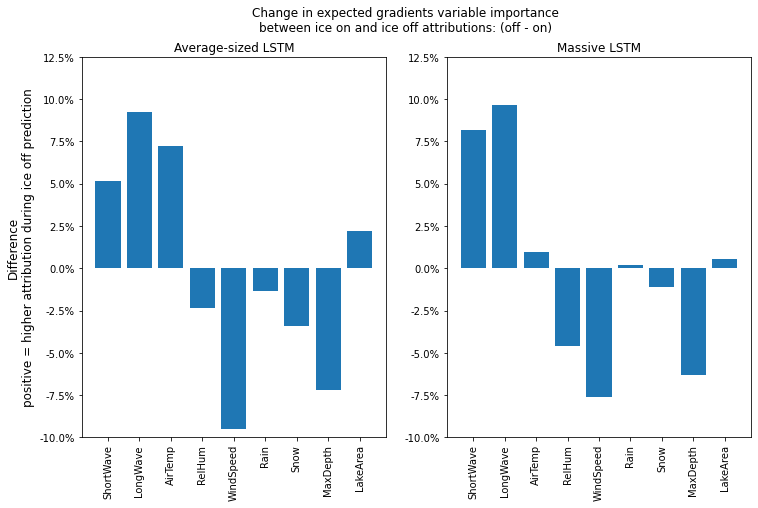

In [16]:
avg_ice_off_percent_change_relative_ice_on = ((avg_rel_abs_attribution_by_var_ice_off -
                                               avg_rel_abs_attribution_by_var_ice_on))

massive_ice_off_percent_change_relative_ice_on = ((massive_rel_abs_attribution_by_var_ice_off -
                                                   massive_rel_abs_attribution_by_var_ice_on))

ymin = np.min([np.min(avg_ice_off_percent_change_relative_ice_on),
               np.min(massive_ice_off_percent_change_relative_ice_on)])
ymax = np.max([np.max(avg_ice_off_percent_change_relative_ice_on),
               np.max(massive_ice_off_percent_change_relative_ice_on)])
ymin = ymin + ymin*0.05
ymax = ymax + ymax*0.05


fig, ax = plt.subplots(1, 2, figsize = (12, 7))

fig.suptitle('Change in expected gradients variable importance\n' +
             'between ice on and ice off attributions: (off - on)')

ax[0].bar(range(len(valid_variables)),
          avg_ice_off_percent_change_relative_ice_on,
          label = 'ice off')
ax[1].bar(range(len(valid_variables)),
          massive_ice_off_percent_change_relative_ice_on,
          label = 'ice off')

ax[0].set_ylabel('Difference\n' +
                 'positive = higher attribution during ice off prediction',
                 fontsize = 12)

for i in range(2):
    ax[i].set_ylim(ymin, ymax)
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)
    ax[i].set_yticks(ax[i].get_yticks(), [str(np.round(100*tick, 1))+'%' for tick in ax[i].get_yticks()])
    
ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Massive LSTM');

##### When using process-based inputs

Both models have increased attribution to the following variables when predicting ice off:

* Short wave radiation
* Long wave radiation
* Lake area

Both models have increased attribution to the following variables when predicting ice on:

* Snow
* Process-based estimate of ice
* Max depth
* Wind speed (minor/subtle for `avg`)

##### When NOT using process-based inputs


Both models have increased attribution to the following variables when predicting ice off:

* Short wave radiation
* Long wave radiation
* Air temperature (minor/subtle for `massive`)
* Lake area (minor/subtle for `massive`)

Both models have increased attribution to the following variables when predicting ice on:

* Wind speed
* Max depth
* Relative humidity 
* Snow (minor/subtle for `massive`)

<br><br><br><br><br>

# How EGs vary by static var

### Add in lat & long

In [17]:
# Read in the MN lake metadata, focusing on coordiantes and lake size
lat_lon_ref_df = pd.read_excel(mapping_reference,
                               usecols=['dow num', 'lat', 'long', 'acres'])
lat_lon_ref_df = lat_lon_ref_df.rename(columns = {'dow num':'DOW'})

# Merge that information with the validation set DOWs
seq_DOWs = pd.DataFrame({'DOW':valid_DOW})
mapping_df = seq_DOWs.merge(lat_lon_ref_df, on='DOW', how = 'left')

### Extract static variables

SpearmanrResult(correlation=0.6074800170780539, pvalue=2.8967217386850654e-06)

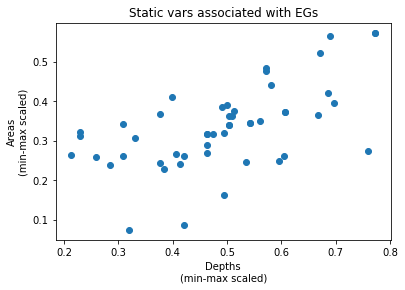

In [18]:
# ID tensor location
depth_i = np.argwhere(valid_variables == 'MaxDepth').item()
area_i = np.argwhere(valid_variables == 'LakeArea').item()
# convert to numpy
#valid_x = valid_x.numpy()
# Extract depths and areas for the subset of data that we have EGs for
depths = valid_x[avg_valid_eg_IDs_ice_on, 0, depth_i]
areas = valid_x[avg_valid_eg_IDs_ice_on, 0, area_i]

# See if/how much they're correlated with each other
plt.scatter(x = depths, y = areas)
plt.xlabel('Depths\n(min-max scaled)')
plt.ylabel('Areas\n(min-max scaled)')
plt.title('Static vars associated with EGs')
spearmanr(depths, areas)

SpearmanrResult(correlation=0.20897889080976945, pvalue=0.14526415275364443) 
 SpearmanrResult(correlation=0.21902017291066284, pvalue=0.12647374265745964) 
 SpearmanrResult(correlation=0.0022098917189079066, pvalue=0.9878478358434155) 
 SpearmanrResult(correlation=0.03093179634966379, pvalue=0.8311399982349276)


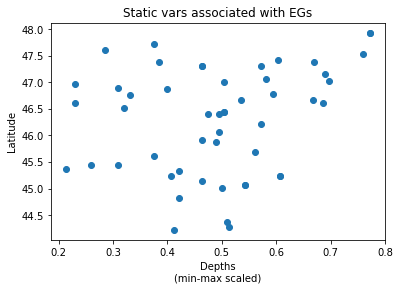

In [19]:
# See if/how much they're correlated with each other
lats = mapping_df['lat'][avg_valid_eg_IDs_ice_on]
longs = mapping_df['long'][avg_valid_eg_IDs_ice_on]
plt.scatter(x = depths, y = lats)
plt.xlabel('Depths\n(min-max scaled)')
plt.ylabel('Latitude')
plt.title('Static vars associated with EGs')
print(spearmanr(depths, lats), '\n',
      spearmanr(areas, lats), '\n',
      spearmanr(depths, longs), '\n',
      spearmanr(areas, longs))

Area and depth are significantly and positively correlated in this sample.

Latitude is independent of the others

In [20]:
# For both model sizes and ice on/off...
avg_num_attributed_days_ice_on_ls = []
massive_num_attributed_days_ice_on_ls = []
avg_num_attributed_days_ice_off_ls = []
massive_num_attributed_days_ice_off_ls = []

# Figure out how many days account for 95% of EG attributions
for i in range(n_eg_fine):
    avg_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(avg_valid_eg_results_ice_on[i, :, :]))
    massive_num_attributed_days_ice_on_ls.append(calc_num_attributed_days(massive_valid_eg_results_ice_on[i, :, :]))
    avg_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(avg_valid_eg_results_ice_off[i, :, :]))
    massive_num_attributed_days_ice_off_ls.append(calc_num_attributed_days(massive_valid_eg_results_ice_off[i, :, :]))

## Ice on

### Plot static variable values versus an approximation of how long the model remembers

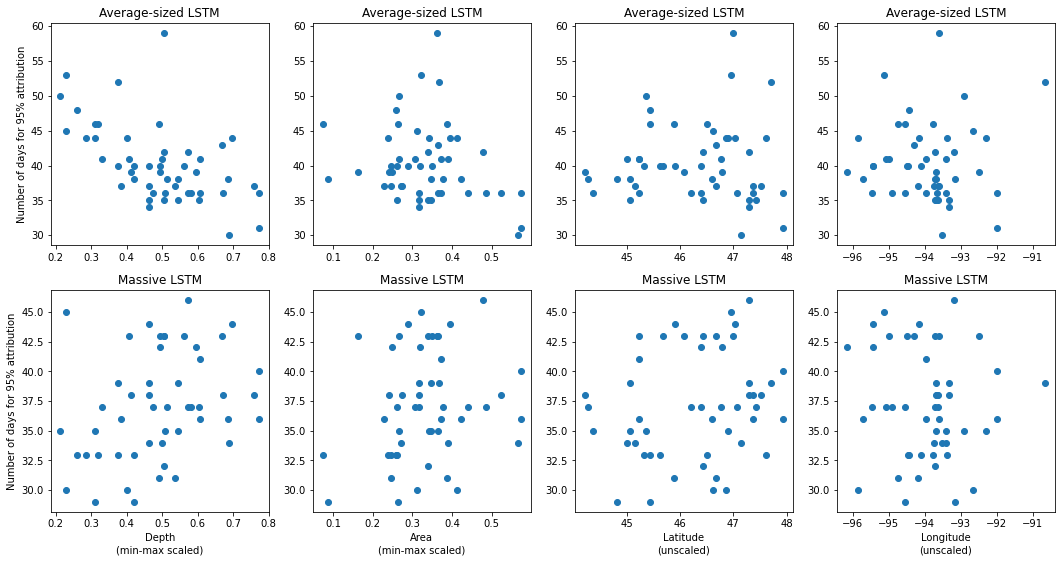

In [21]:
fig, ax = plt.subplots(2, 4, figsize = (18, 9))

# plot static variable values vs how many days account for 95% of EG attributions
ax[0, 0].scatter(depths, avg_num_attributed_days_ice_on_ls)
ax[0, 1].scatter(areas, avg_num_attributed_days_ice_on_ls)
ax[0, 2].scatter(lats, avg_num_attributed_days_ice_on_ls)
ax[0, 3].scatter(longs, avg_num_attributed_days_ice_on_ls)
ax[1, 0].scatter(depths, massive_num_attributed_days_ice_on_ls)
ax[1, 1].scatter(areas, massive_num_attributed_days_ice_on_ls)
ax[1, 2].scatter(lats, massive_num_attributed_days_ice_on_ls)
ax[1, 3].scatter(longs, massive_num_attributed_days_ice_on_ls)

ax[0, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_xlabel('Depth\n(min-max scaled)')
ax[1, 1].set_xlabel('Area\n(min-max scaled)')
ax[1, 2].set_xlabel('Latitude\n(unscaled)')
ax[1, 3].set_xlabel('Longitude\n(unscaled)')
for i in range(4):
    ax[0, i].set_title('Average-sized LSTM')
    ax[1, i].set_title('Massive LSTM');

In [22]:
# Get associated correlations and p-values
for model in [avg_num_attributed_days_ice_on_ls, massive_num_attributed_days_ice_on_ls]:
    print(spearmanr(depths, model))
    print(spearmanr(areas, model))
    print(spearmanr(lats, model))
    print(spearmanr(longs, model))
    print('\n')

SpearmanrResult(correlation=-0.5669044119027287, pvalue=1.7693045870130294e-05)
SpearmanrResult(correlation=-0.1888710779983603, pvalue=0.1889808815632348)
SpearmanrResult(correlation=-0.0846547153171222, pvalue=0.5588773959022035)
SpearmanrResult(correlation=-0.13399246630444897, pvalue=0.3535641211941766)


SpearmanrResult(correlation=0.3493496759251049, pvalue=0.012893561619093054)
SpearmanrResult(correlation=0.22535759472664407, pvalue=0.11559587888006416)
SpearmanrResult(correlation=0.22106965759555453, pvalue=0.1228746533692391)
SpearmanrResult(correlation=-0.06540308601633764, pvalue=0.6518049331835742)




##### When using process-based inputs

In this small sample and univariate inspection, the models do not appear to have correlated static variables with the amount of time steps they effectively remember.

It may be possible that a fuller inspection - more samples and accounting for differences in air temperature or latitude - may suggest otherwise.

##### When NOT using process-based inputs

Here, we see that the amount of time steps that are effectively remembered are singificantly correlated with max depth, but different models identify opposing patterns. The `massive` model remembers more for deeper lakes while `avg` models remember less for deeper lakes. The difference is largest for shallower lakes, where the `avg` model assigns relatively long memory. This is perhaps bad - in favor of the `massive` model. Newly found that latitude and longitude hold no significant correlations.

<br><br><br><br><br>

## Ice off

### Plot static variable values versus an approximation of how long the model remembers

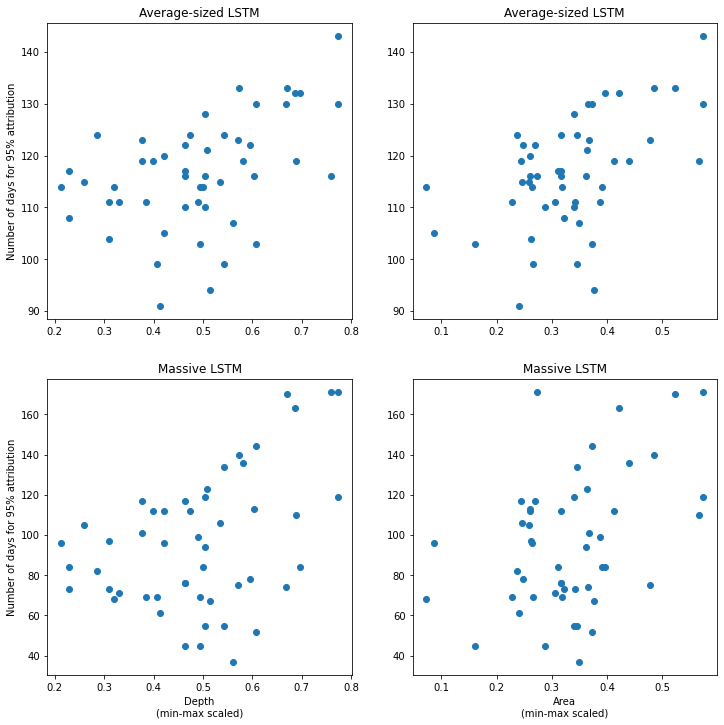

In [23]:
fig, ax = plt.subplots(2, 2, figsize = (12, 12))

ax[0, 0].scatter(depths, avg_num_attributed_days_ice_off_ls)
ax[0, 1].scatter(areas, avg_num_attributed_days_ice_off_ls)
ax[1, 0].scatter(depths, massive_num_attributed_days_ice_off_ls)
ax[1, 1].scatter(areas, massive_num_attributed_days_ice_off_ls)

ax[0, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_ylabel('Number of days for 95% attribution')
ax[1, 0].set_xlabel('Depth\n(min-max scaled)')
ax[1, 1].set_xlabel('Area\n(min-max scaled)')
for i in range(2):
    ax[0, i].set_title('Average-sized LSTM')
    ax[1, i].set_title('Massive LSTM');

In [24]:
for model in [avg_num_attributed_days_ice_off_ls, massive_num_attributed_days_ice_off_ls]:
    print(spearmanr(depths, model))
    print(spearmanr(areas, model))

SpearmanrResult(correlation=0.43594145345164065, pvalue=0.001553303519201546)
SpearmanrResult(correlation=0.4458741582931876, pvalue=0.0011739035013888762)
SpearmanrResult(correlation=0.3434736675452056, pvalue=0.014602137033561257)
SpearmanrResult(correlation=0.33083485631587484, pvalue=0.018940867368577897)


##### When using process-based inputs

Similar to ice on, memory was not generally correlated with static variables. One exception for ice off is that memory and max depth were positively and significantly correlated. This is less intuitive than if ice on was correlated with depth or if ice off was correlated with area; however, it is worth remembering that depth and area were also correlated. 

Overall, the small sample and (mostly) null findings do not provide strong evidence that memory length is strongly controlled by static variables except for one subset of predictions (ice off and lake depth).

##### When NOT using process-based inputs

We find that both models see signficant and positive correlations with both static attributes. This is perhaps good/intuitive because a larger body of water should have more inertia

<br><br><br><br><br>

# Compare memory for both models between ice on and ice off

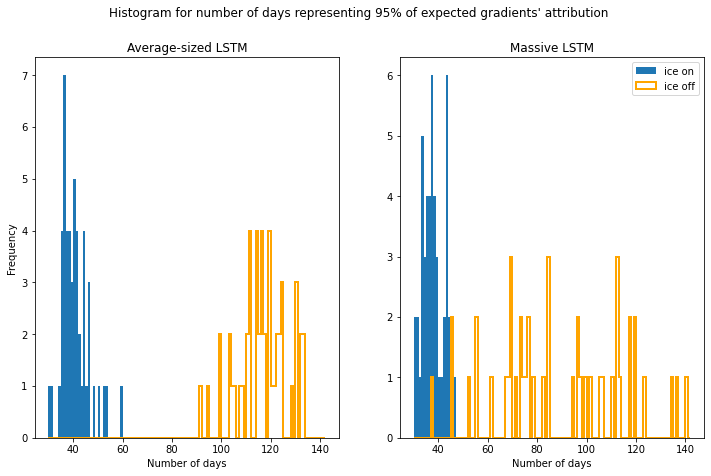

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))

fig.suptitle("Histogram for number of days representing 95% of expected gradients' attribution")

ymin = min(min(avg_num_attributed_days_ice_on_ls), min(avg_num_attributed_days_ice_off_ls))
ymax = max(max(avg_num_attributed_days_ice_on_ls), max(avg_num_attributed_days_ice_off_ls))

ax[0].hist(avg_num_attributed_days_ice_on_ls, bins = range(ymin, ymax))
ax[0].hist(avg_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange')

ax[1].hist(massive_num_attributed_days_ice_on_ls, bins = range(ymin, ymax),
           label = 'ice on')
ax[1].hist(massive_num_attributed_days_ice_off_ls, bins = range(ymin, ymax),
           linewidth = 2, histtype = 'step', color = 'orange',
           label = 'ice off')
plt.legend()

ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Number of days')
ax[1].set_xlabel('Number of days')

ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Massive LSTM');

In [26]:
np.mean(avg_num_attributed_days_ice_on_ls), np.mean(avg_num_attributed_days_ice_off_ls)

(40.32, 116.62)

In [27]:
np.mean(massive_num_attributed_days_ice_on_ls), np.mean(massive_num_attributed_days_ice_off_ls)

(37.12, 95.98)

##### When using process-based inputs

The `avg lstm` remembers longer for both ice on and ice off prediction relative to the `massive lstm`, but both models remember longer when predicting ice off relative to ice on; the latter difference is more striking.

##### When NOT using process-based inputs

The `avg lstm` remembers longer for both ice on and ice off prediction relative to the `massive lstm`, but both models remember longer when predicting ice off relative to ice on; the latter difference is very striking and more variable.

<br><br><br><br><br>

# View Permutation

In [28]:
# original validation losses for scaling
avg_valid_loss = avg_valid_loss_list[avg_valid_loss_list != 0].min()
massive_valid_loss = massive_valid_loss_list[massive_valid_loss_list != 0].min()

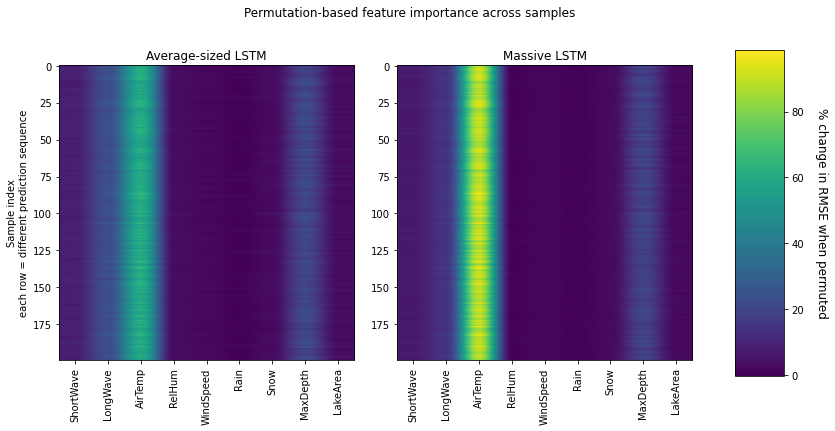

In [29]:
fig, ax = plt.subplots(1, 3, figsize = (13, 6), gridspec_kw={'width_ratios': [6, 6, 1]})

fig.suptitle("Permutation-based feature importance across samples")

avg_change_relative_to_base = 100*(avg_permutation_results - avg_valid_loss) / avg_valid_loss
massive_change_relative_to_base = 100*(massive_permutation_results - massive_valid_loss) / massive_valid_loss

vmin = np.min([np.min(avg_change_relative_to_base), np.min(massive_change_relative_to_base)])
vmax = np.max([np.max(avg_change_relative_to_base), np.max(massive_change_relative_to_base)])

im = ax[0].imshow(avg_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

ax[1].imshow(massive_change_relative_to_base,
             aspect = len(valid_variables) / perm_samples,
             vmin = vmin, vmax = vmax)

ax[0].set_ylabel('Sample index\neach row = different prediction sequence')

for i in range(2):
    ax[i].set_xticks(range(len(valid_variables)),
                     valid_variables,
                     rotation = 90)

cbar = fig.colorbar(im, cax = ax[2])
cbar.set_label('% change in RMSE when permuted',
               fontsize = 12, rotation = 270,
               labelpad = 24)

ax[0].set_title('Average-sized LSTM')
ax[1].set_title('Massive LSTM');


Avg model increasing importance:	 ['Rain' 'WindSpeed' 'Snow' 'RelHum' 'LakeArea' 'ShortWave' 'MaxDepth'
 'LongWave' 'AirTemp'] 

 
Massive model increasing importance:	 ['RelHum' 'Rain' 'WindSpeed' 'LakeArea' 'Snow' 'ShortWave' 'LongWave'
 'MaxDepth' 'AirTemp']


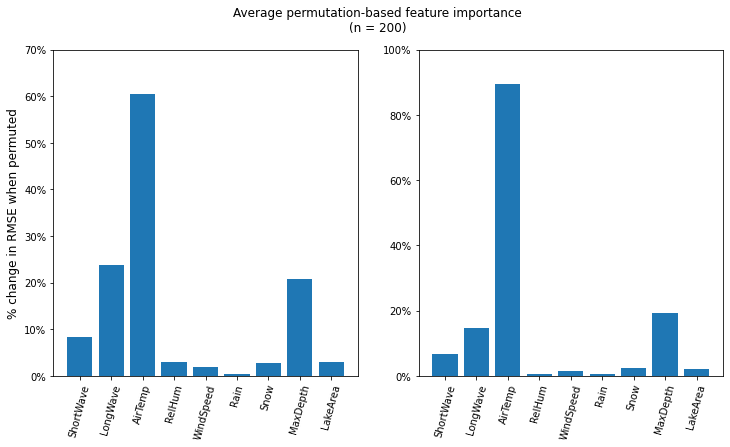

In [30]:
# original validation losses for scaling
avg_valid_loss = avg_valid_loss_list[avg_valid_loss_list != 0].min()
massive_valid_loss = massive_valid_loss_list[massive_valid_loss_list != 0].min()


fig, ax = plt.subplots(1, 2, figsize = (12, 6))

fig.suptitle('Average permutation-based feature importance\n(n = ' + str(perm_samples) + ')')

# plot changes in rmse
ax[0].bar(valid_variables, 100*(np.mean(avg_permutation_results, 0) - avg_valid_loss) / avg_valid_loss)
ax[1].bar(valid_variables, 100*(np.mean(massive_permutation_results, 0) - massive_valid_loss) / massive_valid_loss)
# fix labels
for i in range(2):
    ax[i].set_xticks(range(len(valid_variables)), valid_variables, rotation=75)
    ax[i].set_yticks(ax[i].get_yticks(), [str(int(tick))+'%' for tick in ax[i].get_yticks()])
ax[0].set_ylabel('% change in RMSE when permuted', fontsize = 12)


print('\nAvg model increasing importance:\t', valid_variables[np.argsort(np.mean(avg_permutation_results, 0))], '\n\n',
      '\nMassive model increasing importance:\t', valid_variables[np.argsort(np.mean(massive_permutation_results, 0))])

##### When using process-based inputs

Permutation-based results largely agree with EG results. EG results focus on raw prediction, while permutation focuses on change in performance. 

Permutation results more greatly emphasize the importance of the top-3 variables

##### When NOT using process-based inputs


Permutation-based mostly largely agree with EG results. EG results focus on raw prediction, while permutation focuses on change in performance. 

Permutation results much more greatly emphasize max depth at the expense of incoming radiation.

<br><br><br><br><br>

# View PDP (average of ICE)

Rather than just importance and timing, let's also get an idea for how prediction vary over the range of input variables. This will be performed across many quantiles, including the training min and max, and values beyond the training min and max.

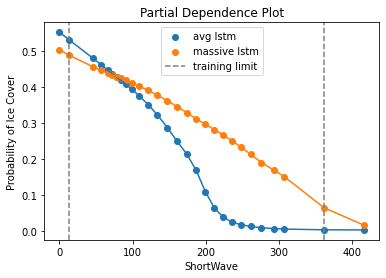

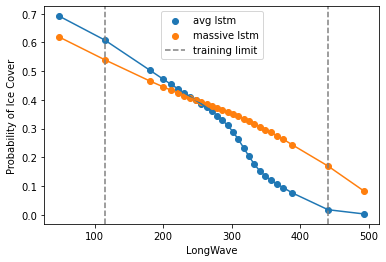

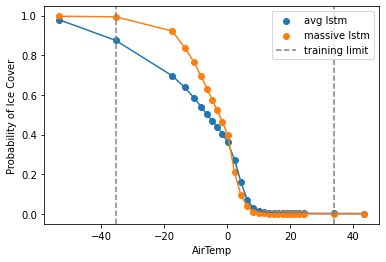

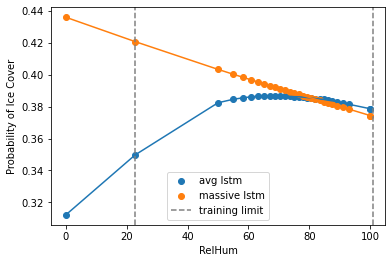

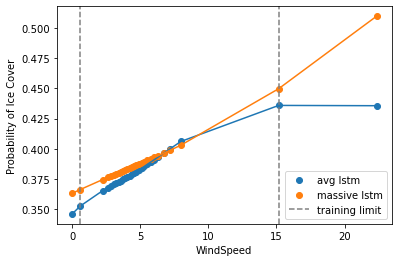

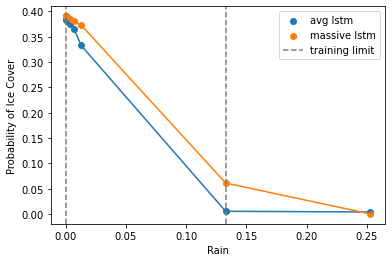

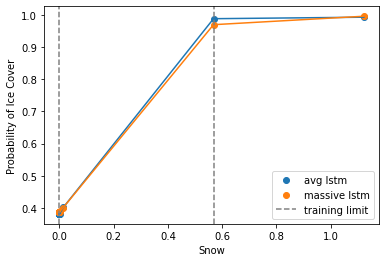

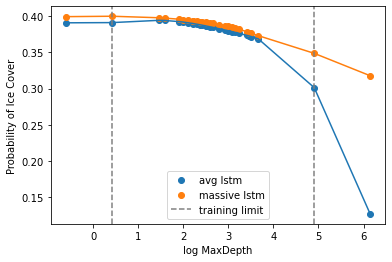

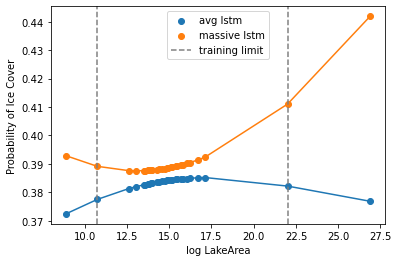

In [31]:
for var_index in range(len(valid_variables)):
    
    var_min = avg_min_max_scalars[var_index, 0].item()
    var_max = avg_min_max_scalars[var_index, 1].item()
    var_name = valid_variables[var_index]
    if var_name in ['MaxDepth', 'LakeArea']:
        var_name = 'log ' + var_name
    
    unscale_factor = var_max - var_min
    
    plt.plot(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    plt.scatter(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'avg lstm')
    plt.plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    plt.scatter(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'massive lstm')
    plt.ylabel('Probability of Ice Cover')
    plt.xlabel(var_name)
    plt.axvline(var_min, color = 'grey', linestyle = '--', label = 'training limit')
    plt.axvline(var_max, color = 'grey', linestyle = '--')
    plt.legend()
    if var_index == 0:
        plt.title('Partial Dependence Plot')
    plt.pause(0.0001)

PDP take-aways:

##### When using process-based inputs

1. Across variables, the models behave very similarly for >90% of the input values.
  * For the top-3 variables, the continuous valued variables highly resemble each other.
2. The `massive lstm` does not exclusively behave wilder at extremes. The model that does display wilder behavior displays nonlinear behavior which extrapolates divergently into out-of-sample values.
  * Notably, it does for `LakeArea` and `LongWave`, althought `LakeArea` operates over substantially smaller changes in prediction.
  * `avg lstm` displays wilder behavior for `RelHum` and `ShortWave`
3. These plots may demonstrate why EGs assign different attribution between models.
  * E.g., `avg lstm`s weighted `RelHum` and `WindSpeed` higher than `massive lstm`s. Likewise, the `avg lstm` assigns a slight nonlinear effect to these variables which prescribes higher probability of ice over these ~90% of their values

##### When NOT using process-based inputs

1. The models can learn noticeably different and even opposing patterns (e.g., positive vs negative; linear vs nonlinear)
2. Behavior at the extremes:
  * The `massive` lstm behaves wilder at the extremes for `LakeArea`
  * The `avg` lstm behaves wilder at the extremes for `MaxDepth` and `RelHum`
    * These values operate over larger changes in % of ice
  * Others are too different or plausible to speak on
3. These plot helps illustrate the difference in EG magnitudes for the top 3 variables. The `massive` model more greatly relies on `AirTemp` and assigns it a stronger threshold effect while assigned the radiation variables more linear effects. These three values are correlated and this ultimately likely means very little.



<br><br><br><br><br>

# Conclusions

##### When using process-based models

* At a coarse, high-level the `avg lstm` and `massive lstm` behave similarly (beyond performance metrics).
<br>

* Expected gradients and permutated-based importance assigned similar variable importance, with permutation-based methods more heavily emphasizing the importance of the top-3 variables. Both methods and models assign top-3 importance to:
  * Air temperature
  * Process-based estimate of ice
  * Process-based estimate of surface water temperature
<br>
<br>

* Similarity of variable importance persists beyond the top-3, but the following disagreements are notable:
  * The `massive lstm` weights process-based estimates of ice higher.
  * The `avg lstm` weights relative humidity and wind speed higher.
<br>
<br>

* For both models, input values occurring in the heat of summer and the dead of winter are not assigned predictive attribution.
<br>

* For both models, predicting the ice off transition assigns predictive attribution further back in time ($\geq 1$ week more).
  * Along these lines, the `avg lstm` remembers for longer than the `massive lstm` in both scenarios, but this is more notable for ice on prediction (8 additional days compared to 3 additional days).
  * Notably, when predicting ice on, both models assigned higher attribution to relative humidity, wind speed, snowfall and lake depth, and when predicting ice off, both models assigned higher attribution to lake area and measures of incoming radiation.
<br> 
<br>
   
* Static variables (area and depth) mostly did not significantly affect the size of the attributed temporal window (where 95% of predictive attribution was assigned, unit = days). It may be possible that a larger sample or an analysis including the effect of temperature and/or latitude could find otherwise.
  * one exception is that deeper lakes (which were positively and signficantly correlated with larger area lakes) were positively and significantly correlated with increased memory.

<br>

* Across 90% of the range of input values, the models behave very similarly at high-level trend directions and shapes.
* The `massive lstm` (>18 million parameters) did not exclusively behave wilder in out-of-sample input values relative to the `avg lstm` (~2000 parameters)
  * The `massive lstm` extrapolates into new values of lake area and long wave radiation more divergently
  * The `avg lstm` extrapolates into new values of relative humidity and short wave radiation more divergently
  
  
*Caveat*: PDP-approach for exploring prediction at out-of-sample input values varies one input variable at a time into new values while the others inputs are using in-sample values. This has the limitation of considering potentially unrealistic values (e.g., unrealistic combinations of rain fall and incoming radiation) and may not accurately consider how multiple variable may covary into out-of-sample space.

##### When not using process-based models

* At a coarse, high-level the `avg` and `massive` lstm behave similar, but individual feature-level patterns can notably vary
<br>

* Expected gradients and permutation-based importance identify the same top-4 features with differing order:
  * Air temperature
  * Longwave radiation
  * Max depth
  * Shortwave radiation
<br>
<br>
  
* Variable ranking is less consistent across methods below the top-4 features, however `rain` is most consistently seen as less important
  * Permutation-based feature importance recognizes static features more
  * EGs recognize dynamic features more
<br>
<br>
  
* For both models, input values occuring in the heat of summer are not assigned predictive attribution
<br>

* For both models, predicting the ice off transition assigns predictive attribution further back in time (on the order of $2$ additional months).
  * Along these lines, the `avg lstm` remembers for longer than the `massive lstm` in both scenarios, but this is more notable for ice off prediction (20 additional days compared to 3 additional days).
  * Notably, when predicting ice on, both models assigned higher attribution to wind speed, lake depth, and relative humidity and when predicting ice off, both models assigned higher attribution to measures of incoming radiation.
<br>
<br>

* Static variables (area and depth) were found to significantly correlate with the size of the attributed temporal window (where 95% of predictive attribution was assigned, unit = days).
  * ice-off had the clearest findings, where more expansive and deeper lakes were independently found to have larger memory
  * depth was significantly but opposingly correlated with ice-on memory. The `massive` models positive correlation was more plausible
  * one exception is that more expansive lakes were not correlated with ice-on memory
<br>
<br>

* At the feature-level, there was not convergence between the models' learned patterns. The models found disagreeing levels of positive/negative correlation, linear/nonlinear effects, and threshold points/strengths. The `avg` lstm deviated into larger predictive changes when given new out-of-sample feature values (e.g., for `MaxDepth` and `RelHumid`).

<br><br><br>

### Paper figure - not yet updated

In [32]:
valid_variables

array(['ShortWave', 'LongWave', 'AirTemp', 'RelHum', 'WindSpeed', 'Rain',
       'Snow', 'MaxDepth', 'LakeArea'], dtype='<U15')

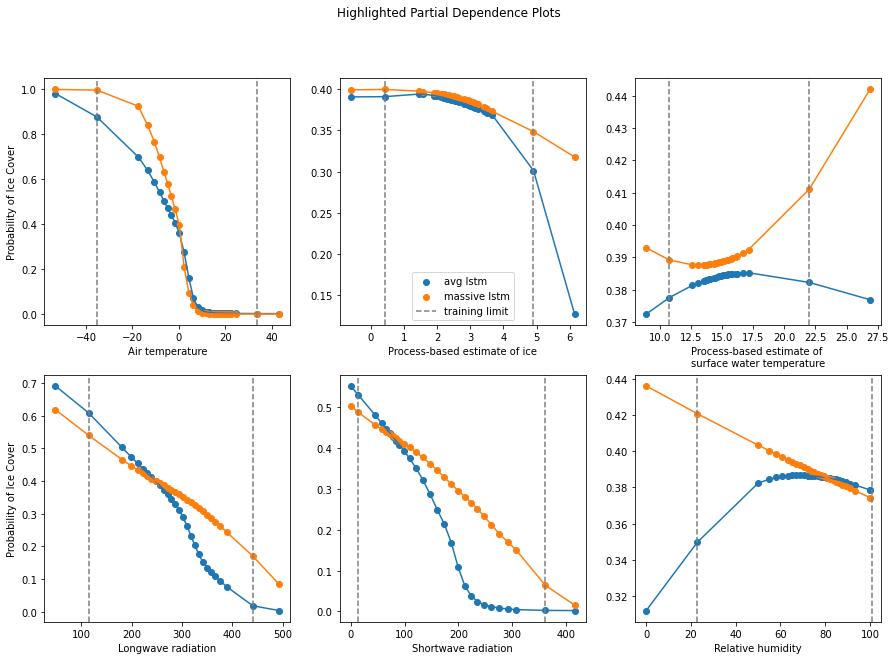

In [33]:
nice_labels = ['Air temperature', 'Process-based estimate of ice', 'Process-based estimate of \nsurface water temperature',
               'Longwave radiation', 'Shortwave radiation', 'Relative humidity']

fig, ax = plt.subplots(2, 3, figsize = (15, 10))

fig.suptitle('Highlighted Partial Dependence Plots')

count = 0
for var_index in [2, 7, 8, 1, 0, 3]:
    
    if count < 3:
        i = 0
        j = count
    else:
        i = 1
        j = count - 3
    
    var_min = avg_min_max_scalars[var_index, 0].item()
    var_max = avg_min_max_scalars[var_index, 1].item()
    var_name = valid_variables[var_index]
    if var_name in ['MaxDepth', 'LakeArea']:
        var_name = 'log ' + var_name
    
    unscale_factor = var_max - var_min
    
    ax[i, j].plot(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    ax[i, j].scatter(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'avg lstm')
    ax[i, j].plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    ax[i, j].scatter(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'massive lstm')
    if j == 0:
        ax[i, j].set_ylabel('Probability of Ice Cover')
    #ax[i, j].set_ylim(0, 1)
    ax[i, j].set_xlabel(nice_labels[count])
    ax[i, j].axvline(var_min, color = 'grey', linestyle = '--', label = 'training limit')
    ax[i, j].axvline(var_max, color = 'grey', linestyle = '--')
    if i == 0 and j == 1:
        ax[i, j].legend()
    count += 1
    
plt.savefig('../../highlighted_PDPs.PNG', dpi = 300, bbox_inches = 'tight')

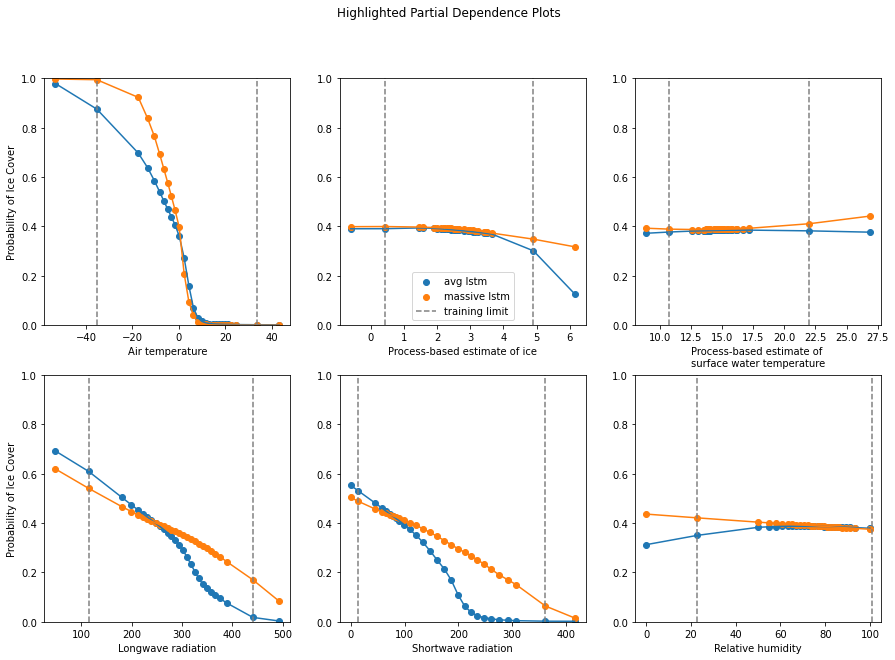

In [34]:
nice_labels = ['Air temperature', 'Process-based estimate of ice', 'Process-based estimate of \nsurface water temperature',
               'Longwave radiation', 'Shortwave radiation', 'Relative humidity']

fig, ax = plt.subplots(2, 3, figsize = (15, 10))

fig.suptitle('Highlighted Partial Dependence Plots')

count = 0
for var_index in [2, 7, 8, 1, 0, 3]:
    
    if count < 3:
        i = 0
        j = count
    else:
        i = 1
        j = count - 3
    
    var_min = avg_min_max_scalars[var_index, 0].item()
    var_max = avg_min_max_scalars[var_index, 1].item()
    var_name = valid_variables[var_index]
    if var_name in ['MaxDepth', 'LakeArea']:
        var_name = 'log ' + var_name
    
    unscale_factor = var_max - var_min
    
    ax[i, j].plot(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
             # reshape lumps all lakes and times together by variable
             np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    ax[i, j].scatter(avg_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(avg_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'avg lstm')
    ax[i, j].plot(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1))
    ax[i, j].scatter(massive_valid_set_ICE_vals[var_index]*unscale_factor + var_min,
                np.mean(massive_valid_set_ICE_preds[var_index].reshape(resolution + 3, -1), 1),
                label = 'massive lstm')
    if j == 0:
        ax[i, j].set_ylabel('Probability of Ice Cover')
    ax[i, j].set_ylim(0, 1)
    ax[i, j].set_xlabel(nice_labels[count])
    ax[i, j].axvline(var_min, color = 'grey', linestyle = '--', label = 'training limit')
    ax[i, j].axvline(var_max, color = 'grey', linestyle = '--')
    if i == 0 and j == 1:
        ax[i, j].legend()
    count += 1
    
plt.savefig('../../highlighted_PDPs_fullYaxis.PNG', dpi = 300, bbox_inches = 'tight')